In [82]:
import matplotlib.pyplot as plt
import brokenaxes
import pickle as pkl

from scipy.ndimage import interpolation
import ipdb
import glob
import numpy as np

# Help: overall performance

In [25]:
def plot_bar_reward(results):
    # results: dict of Methods, for each method dict of tasks
    methods = list(results.keys())
    task_names = list(results[methods[0]].keys())
    fig = plt.figure(figsize=(13,5))
    ax = fig.subplots()

    w = 22
    x_pos = np.arange(len(task_names)) * len(methods) * w
    metric = 'SWS'
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    iter_col = 0
    for it, (method_name, result) in enumerate(results.items()):

        method = method_name
        offset = it + 0.5 - len(methods)/2
        wb = w * 12
        iter_col += 1
        if iter_col == len(colors):
            iter_col = 0
        curr_col = colors[iter_col]
        method = method.replace('randomgoal', 'randomgoal_corrected')

        x = [result[task]['Reward'][0] for task in task_names]
        xerr = [result[task]['Reward'][1] for task in task_names]
        ax.bar(x_pos*w+offset*wb,  x, width=wb*1.0,
               yerr=xerr, label=method,
               align='center', alpha=0.5, ecolor='black', capsize=3, edgecolor='white')
    ax.set_xticks(x_pos*w)
    ax.set_ylim([0., 1.1])

    labels = task_names
    ax.set_xticklabels(labels, fontsize=17, rotation=12)
    plt.ylabel(r'Reward', fontsize=20)


    plt.legend(loc='upper center', ncol=5, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # matplotlib.rc('xtick', labelsize=20
    plt.grid(axis='y')

    # plt.grid(True, linestyle='--', axis='y')
    plt.savefig('reward_plot_all.pdf')


In [26]:
def plot_scatter(results, task_name='all'):
    # res: dictionaru of metridc, for every metric dictionary of tasks
    fig = plt.figure(figsize=(10,7))

    alph = 0.8
    bax = brokenaxes.brokenaxes(ylims=((-0.24, 0.66), (1.0, 1.4)), hspace=.05)
    for method_name, result in results.items():
        res = result['all']

        bax.errorbar(res['SR'][0], res['SP'][0], xerr=res['SR'][1], 
                     yerr=res['SP'][1], label=method_name, alpha=alph, fmt='--o', capsize=3)
        bax.annotate(method_name, (res['SR'][0]+0.005, res['SP'][0]+0.04), fontsize=15)

        print(res['SR'], res['SP'])

    bax.set_xlabel('Success Rate', fontsize=20)
    bax.set_xlim(0.72, 1.03)

    bax.set_ylabel('Speed Up', fontsize=20)
    # bax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ax.set_xticklabels(labels, fontsize=17, rotation=12)
    # print(classes)


    # plt.legend(loc='upper center', ncol=5, fontsize=15)

    bax.tick_params(axis='both', which='major', labelsize=15)


    # bax.set_xticks(fontsize=12)
    # plt.yticks(fontsize=12)
    # bax.grid()
    bax.grid(axis='both', which='major', ls='-')
    bax.grid(axis='both', which='minor', ls='--', alpha=0.5)

    # plt.grid()
    # plt.tight_layout()
    plt.savefig('scatter_plot_filter_slides_2.eps')

    plt.legend()

In [27]:
with open('../../results_eval_helping.pik', 'rb') as f:
    results = pkl.load(f)
print(results.keys())

dict_keys(['Main', 'GT', 'Uniform', 'w/o InvPlanning', '1 Goal', 'Ours'])


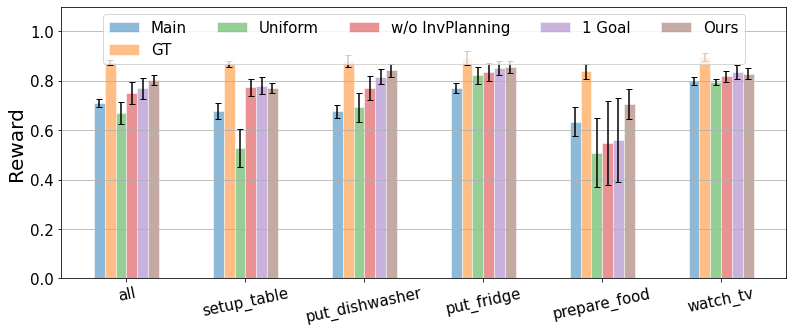

In [28]:
plot_bar_reward(results)

[0.99, 0.0099498743710662] [0.0, 0.0]
[1.0, 0.0] [1.1910045169270578, 0.12630560249489298]
[1.0, 0.0] [-0.05668537505351769, 0.06762079023390472]
[0.95, 0.048733971724044825] [0.29090579052530935, 0.09268304404001619]
[0.95, 0.048733971724044825] [0.42811987022234793, 0.09024596781415711]
[1.0, 0.0] [0.43982622371265295, 0.10289322471013539]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


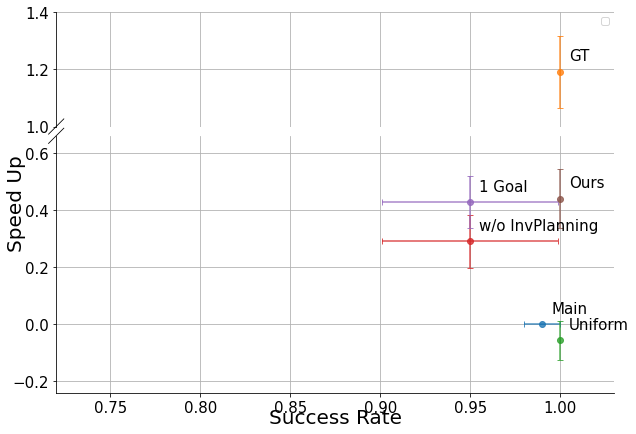

In [29]:
with open('../../results_eval_helping.pik', 'rb') as f:
    results = pkl.load(f)
plot_scatter(results)

# Goal Inference
How does goal inference change for different methods?

In [154]:
eps = 1e-9
def bin_data(res, length, nbins=20, debug=False):
    # put data in nbins according to episode length
    # res: #seeds x time_steps 
    length = int(length)
    try:
        nseeds = res.shape[0]
    except:
        idpb.set_trace()
    bin_data = np.zeros((nbins, nseeds))
    for seed in range(nseeds):
        zoom_val = nbins*1.0 / length
        val = interpolation.zoom(res[seed, :length], zoom_val)
        try:
            bin_data[:, seed] = val
        except:
            ipdb.set_trace()
    points_interp = np.linspace(0, length-1, nbins)

    bin_data_mean = bin_data.mean(1)
    return bin_data_mean



def get_files(file_path, use_posterior=False):
    if use_posterior:
        files = [file for file in glob.glob('{}/logs*.pkl'.format(file_path)) if 'posterior' in file]
        if len(files) == 0:
            files = [file for file in glob.glob('{}/logs*.pik?'.format(file_path)) if 'posterior' in file]
            print(file_path)
            
    else:
        files = [file for file in glob.glob('{}/logs*.pkl'.format(file_path)) if 'posterior' not in file]
        if len(files) == 0:
            files = [file for file in glob.glob('{}/logs*.pik?'.format(file_path)) if 'posterior' in file]
            print(file_path)
    return files



def compute_metrics(pred_task, gt_task, length, debug=False):
    # pred_task: [#seeds, t, #preds]
    # gt_task: [t, #preds]
    
    gt_task = gt_task[None, ...]
    length = int(length)
    T = pred_task.shape[1]
    gt_task_d = gt_task[None, ...]
    len_mask = np.zeros(T)
    len_mask[:length] = 1
    
    gt_p = gt_task / gt_task.sum(-1)[..., None]
    pos_gt_p = (gt_task > 0) / ((gt_task > 0).sum(-1)[..., None] + eps)
    pred_p = (pred_task > 0) / ((pred_task > 0).sum(-1)[..., None] + eps)
    
    accuracy = (((gt_task == pred_task) * pos_gt_p).sum(-1)).mean(0)[None, ...]
    recall = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).mean(0)[None, ...]
    prec = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).mean(0)[None, ...]
    
    accuracymax = (((gt_task == pred_task) * pos_gt_p).sum(-1)).max(0)[None, ...]
    recallmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).max(0)[None, ...]
    precmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).max(0)[None, ...]
    
    
    max_gt_pred = gt_task.max(-1)
    std = np.std(pred_task, axis=0).mean(-1)[None, ...]
    

    if debug:
        ipdb.set_trace()
    dict_res = {
        'gt_task': gt_task,
        'recall_tsteps': recall,
        'accuracy_tsteps': accuracy,
        'precision_tsteps': prec,
        'std_tsteps': std,
        'recallmax_tsteps': recallmax,
        'accuracymax_tsteps': accuracymax,
        'precisionmax_tsteps': precmax,
        'std_tsteps': std
    }
    return dict_res

def take_average(list_metrics):
    num_t = len(list_metrics)
    if (num_t == 0):
        ipdb.set_trace()
    res_mean, res_std = {}, {}
    for name in list_metrics[0].keys():
        res_mean[name] = np.concatenate([metric[name][None, ...] for metric in list_metrics]).mean(0)
        res_std[name] = np.concatenate([metric[name][None, ...] for metric in list_metrics]).std(0) / np.sqrt(num_t)
    return res_mean, res_std

In [155]:
def plot_bar(metric, names=None):
    curve_names = list(metric.keys())
    
    if names is None:
        names = metric[curve_names[0]][0].keys()
        names = sorted([name for name in names])
        
    fig, ax_plots = plt.subplots(int(len(names)/2)+1, 2, figsize=(12, 3*len(names)))
    final_metric_dict = metric
    ax = plt.gca()
    colors=[next(ax._get_lines.prop_cycler)['color'] for _ in range(len(curve_names))]
    for i, curve_name in enumerate(curve_names):
        if i >= len(names):
            continue
        color = colors[i]
        content = metric[curve_name][0]
        std_metric = metric[curve_name][1]

        for index, name_metric in enumerate(names):
            curr_ax = ax_plots[index//2, index%2]
            nb = len(content[name_metric])
            x = np.arange(nb)
            mean_return = content[name_metric]
            mean_se = std_metric[name_metric]
            ymin = mean_return - mean_se
            ymax = mean_return + mean_se
            curr_ax.plot(x, mean_return, label=curve_name, color=color)
            curr_ax.fill_between(x, ymin, ymax, alpha=0.1, color=color)

    for ind, ax in enumerate(list(ax_plots.reshape(-1))):
        if ind >= len(names):
            continue
        ax.legend()
        ax.set_title(names[ind])
        ax.grid()
        ax.set_xlabel("Task Progress")

## Goal Prediction Offline

Loading ../../results/results_smallset_inference_offline/det_0.05


/tmp/ipykernel_28771/2715847373.py:13: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  val = interpolation.zoom(res[seed, :length], zoom_val)


Loading ../../results/results_smallset_inference_offline/det
Loading ../../results/results_smallset_inference_offline/VAE.KL.1.0
Loading ../../results/results_smallset_inference_offline/VAE.KL.0.001
Loading ../../results/results_smallset_inference_offline/det_0.1
Loading ../../results/results_smallset_inference_offline/VAE.KL.0.001_dr0.1
Loading ../../results/results_smallset_inference_offline/VAE.KL.0.001_dr0.05


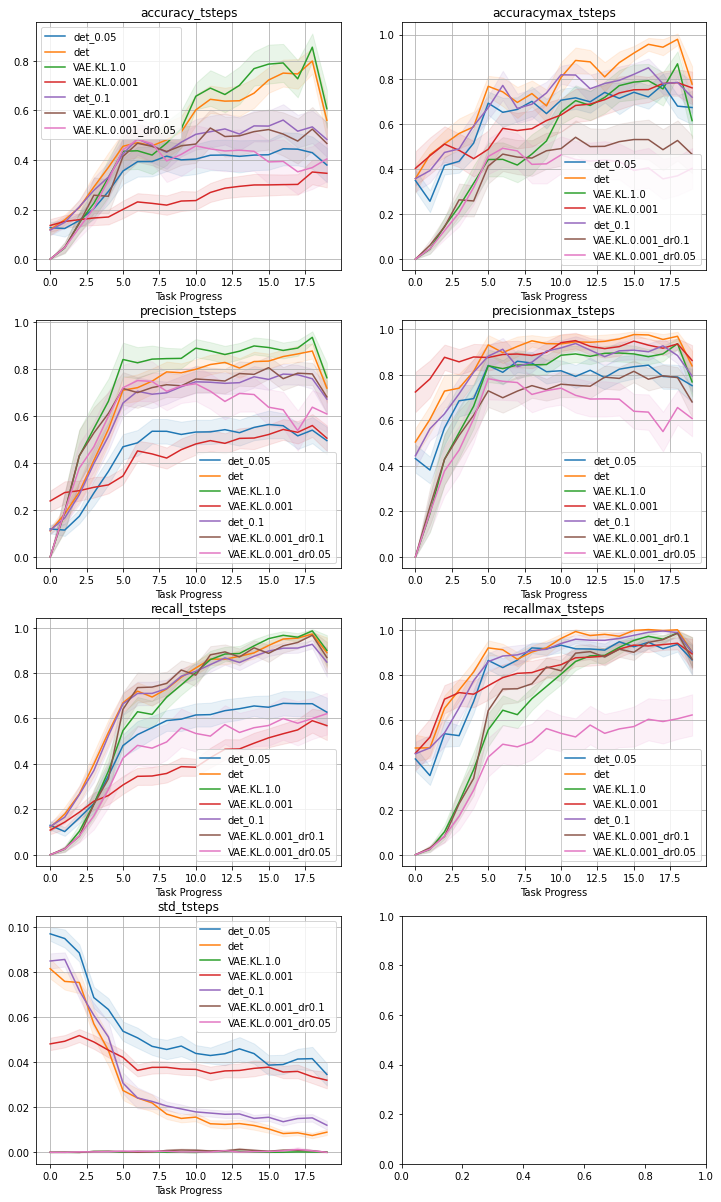

In [101]:
# exp_name = deterministic
nbins = 20
init_path = '../../results/results_smallset_inference_offline'
exp_names = glob.glob(f'{init_path}/*')
all_results = {}
for exp_name in exp_names:
    print(f"Loading {exp_name}")
    file_path = exp_name
    exp_name = exp_name.split('/')[-1]
    files_interest = get_files(file_path)
    
    i = 0
    current_results_experiment = []
    for cfile_name in files_interest:
        with open(cfile_name, 'rb') as f:
            cont = pkl.load(f)
        results = compute_metrics(cont['pred_task'][1:], cont['gt_task'], cont['length'])
        results_bin = {}
        for resultname, resultval in results.items():
            if 'tsteps' in resultname:
                results_bin[resultname] = bin_data(resultval, cont['length'], nbins)
        current_results_experiment.append(results_bin)
    mean_exp, std_exp = take_average(current_results_experiment)
    all_results[exp_name] = (mean_exp, std_exp)


plot_bar(all_results)

# Goal Prediction with particles

Loading ../../results/results_smallset_inference_online/VAE.KL.1.0


/tmp/ipykernel_28771/470537173.py:13: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  val = interpolation.zoom(res[seed, :length], zoom_val)


Loading ../../results/results_smallset_inference_online/det
Loading ../../results/results_smallset_inference_online/det_0.05


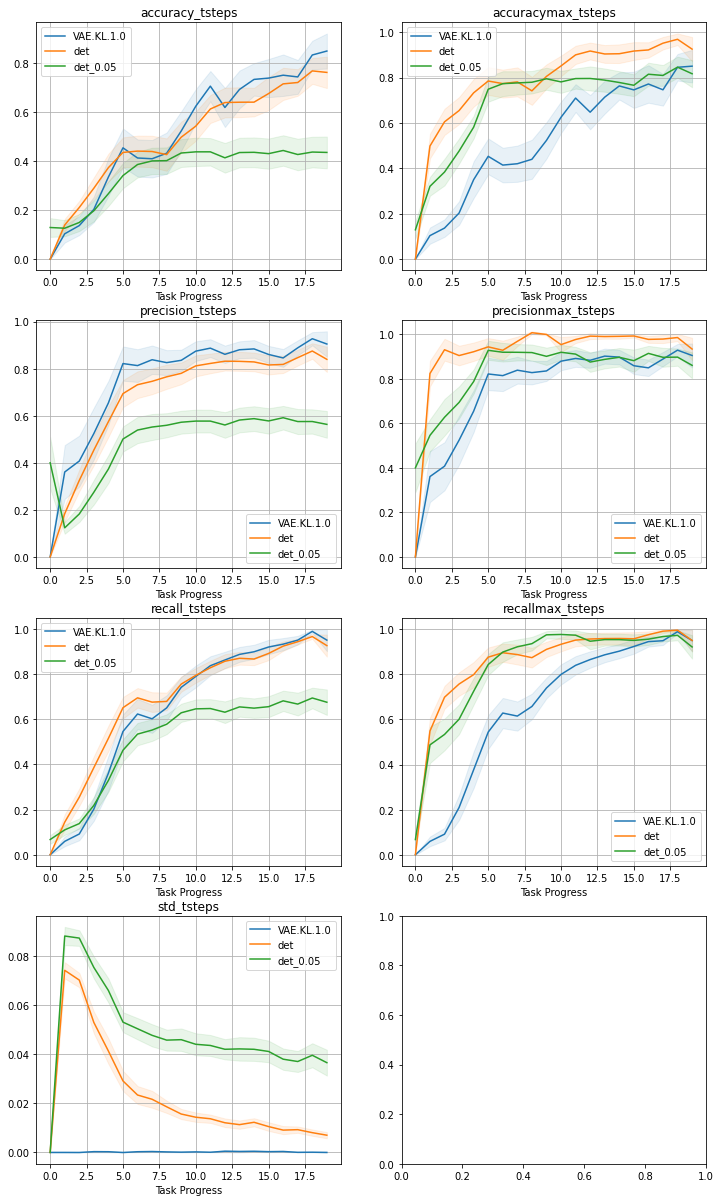

In [162]:
# exp_name = deterministic
nbins = 20
init_path = '../../results/results_smallset_inference_online'
exp_names = glob.glob(f'{init_path}/*')
all_results = {}
for exp_name in exp_names:
    print(f"Loading {exp_name}")
    file_path = exp_name
    exp_name = exp_name.split('/')[-1]
    files_interest = get_files(file_path)
    
    i = 0
    current_results_experiment = []
    for cfile_name in files_interest:
        with open(cfile_name, 'rb') as f:
            file_cont = pkl.load(f)
        
        length = len(file_cont)
        pred_time = []
        for pr in file_cont:
            pred_particles = np.concatenate([pr_part[None, None, :] for pr_part in pr['pred_task']])
            pred_time.append(pred_particles)
        pred_task = np.concatenate(pred_time, 1)
        
        gt_task = np.concatenate([gt_time['gt_task'][None, :] for gt_time in file_cont])
        
        results = compute_metrics(pred_task, gt_task, length)
        results_bin = {}
        for resultname, resultval in results.items():
            if 'tsteps' in resultname:
                results_bin[resultname] = bin_data(resultval, length, nbins)
        current_results_experiment.append(results_bin)
    mean_exp, std_exp = take_average(current_results_experiment)
    all_results[exp_name] = (mean_exp, std_exp)


plot_bar(all_results)

In [161]:
ls -lt ../../results/results_smallset_inference_online

total 17
drwxrwsr-x 2 xavierpuig vision-torralba 20 May  7 12:38 det_0.05/
drwxrwsr-x 2 xavierpuig vision-torralba 22 May  7 12:28 det/
